In [1]:
#this script allows you to convert any earth map from python to civmap
#you can modify latitude,longitude and projection to get any earth map
#in the demonstration below I use basemap package
#technically u can use any map even non-map 
#u just have to map different pixel colors to terrains
#it also automatically generates natural wonders
#geotags resources, continents and true start locations
#based upon coordinates provided in the spreadsheets
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import sklearn.mixture
os.chdir('K:/ecole/github/televerser/civ6')

### read civmap

In [2]:
#create copy then rename
#i strongly encourage you to create a blank map then load it into python
#the directory of customized map from world builder
# C:\Users\your_user_name\Documents\My Games\Sid Meier's Civilization VI\Saves\WorldBuilder
os.system('copy nouveau.Civ6Map copie.Civ6Map')

#essentially civ6map is a sql database
os.rename('nouveau.Civ6Map','civ.db')

### global variables

In [3]:
features=['FEATURE_GEOTHERMAL_FISSURE',
 'FEATURE_VOLCANIC_SOIL',
 'FEATURE_VOLCANO',
 'FEATURE_ICE',
 'FEATURE_REEF',
 'FEATURE_JUNGLE',
 'FEATURE_FOREST',
 'FEATURE_BURNT_JUNGLE',
 'FEATURE_BURNING_JUNGLE',
 'FEATURE_BURNING_FOREST',
 'FEATURE_BURNT_FOREST',
 'FEATURE_MARSH',
 'FEATURE_FLOODPLAINS_GRASSLAND',
 'FEATURE_FLOODPLAINS_PLAINS',
 'FEATURE_FLOODPLAINS',
   'FEATURE_OASIS',]

resources=['RESOURCE_FISH', 'RESOURCE_WHALES', 
        'RESOURCE_PEARLS',
       'RESOURCE_CRABS', 'RESOURCE_DEER',
           'RESOURCE_TRUFFLES',
       'RESOURCE_SHIPWRECK', 'RESOURCE_FURS',
       'RESOURCE_ANTIQUITY_SITE', 'RESOURCE_SHEEP',
           'RESOURCE_STONE',
       'RESOURCE_WHEAT', 'RESOURCE_WINE',
           'RESOURCE_DYES',
       'RESOURCE_CATTLE', 'RESOURCE_TURTLES',
       'RESOURCE_IVORY', 'RESOURCE_HONEY',
           'RESOURCE_COCOA',
       'RESOURCE_SALT', 'RESOURCE_BANANAS',
           'RESOURCE_COFFEE',
       'RESOURCE_TOBACCO', 'RESOURCE_SUGAR',
           'RESOURCE_RICE',
       'RESOURCE_CITRUS', 'RESOURCE_SPICES',
           'RESOURCE_INCENSE',
       'RESOURCE_MAIZE', 'RESOURCE_JADE',
           'RESOURCE_COTTON',
       'RESOURCE_OLIVES', 'RESOURCE_SILK',
           'RESOURCE_TEA',
       'RESOURCE_MERCURY', 'RESOURCE_MARBLE',
           'RESOURCE_AMBER']

In [4]:
#map terrain into different colors for viz
terrain2color={'TERRAIN_COAST': '#16396c',
 'TERRAIN_DESERT': '#b18e35',
 'TERRAIN_DESERT_HILLS': '#b18e35',
 'TERRAIN_DESERT_MOUNTAIN': '#b18e35',
 'TERRAIN_GRASS': '#2b3317',
 'TERRAIN_GRASS_HILLS': '#2b3317',
 'TERRAIN_GRASS_MOUNTAIN': '#2b3317',
 'TERRAIN_OCEAN': '#050e24',
 'TERRAIN_PLAINS': '#90aa6e',
 'TERRAIN_PLAINS_HILLS': '#90aa6e',
 'TERRAIN_PLAINS_MOUNTAIN': '#90aa6e',
 'TERRAIN_SNOW': '#eceeee',
 'TERRAIN_SNOW_HILLS': '#eceeee',
 'TERRAIN_SNOW_MOUNTAIN': '#eceeee',
 'TERRAIN_TUNDRA': '#a09b90',
 'TERRAIN_TUNDRA_HILLS': '#a09b90',
 'TERRAIN_TUNDRA_MOUNTAIN': '#a09b90'}

#map colors into different terrains
#remove mountain tiles for simplicity
color2terrain={
 '#90aa6e': 'TERRAIN_PLAINS',
 '#16396c': 'TERRAIN_COAST',
 '#b18e35': 'TERRAIN_DESERT',
 '#2b3317': 'TERRAIN_GRASS',
 '#eceeee': 'TERRAIN_SNOW',
 '#a09b90': 'TERRAIN_TUNDRA',
 '#050e24': 'TERRAIN_OCEAN',}

#land and sea mask for sanity check
masque={
'#000000': 'TERRAIN_PLAINS',
'#FFFFFF': 'TERRAIN_COAST',}

In [5]:
#scaler determines the cutoff latitude
scaler=140000

#determine the map centre
lon_centre=-70
lat_centre=80

#one of the projection types
projection_type='aeqd'

In [6]:
#useful for players table construction
human_player={'ID': {0: 0},
 'CivilizationType': {0: 'UNDEFINED'},
 'LeaderType': {0: 'UNDEFINED'},
 'CivilizationLevelType': {0: 'CIVILIZATION_LEVEL_FULL_CIV'},
 'AgendaType': {0: ''},
 'Status': {0: 'Human'},
 'Handicap': {0: None},
 'StartingPosition': {0: None},
 'Color': {0: None},
 'Initialized': {0: 0}}

ai_civs={'ID': {1: 1},
 'CivilizationType': {1: 'UNDEFINED'},
 'LeaderType': {1: 'UNDEFINED'},
 'CivilizationLevelType': {1: 'CIVILIZATION_LEVEL_FULL_CIV'},
 'AgendaType': {1: ''},
 'Status': {1: 'AI'},
 'Handicap': {1: None},
 'StartingPosition': {1: None},
 'Color': {1: None},
 'Initialized': {1: 0}}

ai_cities={'ID': {23: 25},
 'CivilizationType': {23: 'RANDOM'},
 'LeaderType': {23: 'RANDOM'},
 'CivilizationLevelType': {23: 'CIVILIZATION_LEVEL_CITY_STATE'},
 'AgendaType': {23: ''},
 'Status': {23: 'AI'},
 'Handicap': {23: None},
 'StartingPosition': {23: None},
 'Color': {23: None},
 'Initialized': {23: 1}}

In [7]:
#impassable terrains
impassable_terrains=['TERRAIN_DESERT_MOUNTAIN',
 'TERRAIN_GRASS_MOUNTAIN',
 'TERRAIN_PLAINS_MOUNTAIN',
 'TERRAIN_SNOW_MOUNTAIN',
 'TERRAIN_TUNDRA_MOUNTAIN']

In [8]:
#the boundary of each continent in polygon shape
continent_area={'CONTINENT_ARCTICA':
                {'lat': [65, 90, 90, 65],
                       'lon': [-180, -180, 180, 180]},
 'CONTINENT_ANTARCTICA': {'lat': [-90, -60, -60, -90],
  'lon': [-180, -180, 180, 180]},
 'CONTINENT_SOUTH_AMERICA': {'lat': [-60, 10, 10, -60],
  'lon': [-180, -180, -30, -30]},
 'CONTINENT_AMERICA': {'lat': [30, 10, 10, 30],
  'lon': [-180, -180, -30, -30]},
 'CONTINENT_NORTH_AMERICA': {'lat': [30, 65, 65, 30],
  'lon': [-180, -180, -30, -30]},
 'CONTINENT_ZEALANDIA': {'lat': [-60, -30, -30, -60],
  'lon': [160, 160, 180, 180]},
 'CONTINENT_VAALBARA': {'lat': [-60, -10, -10, -60],
                        'lon': [40, 40, 120, 120]},
 'CONTINENT_AUSTRALIA': {'lat': [-60, -10, -10, -60],
  'lon': [120, 120, 160, 160]},
 'CONTINENT_CONGO_CRATON': {'lat': [-10, 0, 0, -10],
                            'lon': [-30, -30, 60, 60]},
 'CONTINENT_KALAHARIA': {'lat': [-60, -10, -10, -60],
                         'lon': [-30, -30, 40, 40]},
 'CONTINENT_AFRICA': {'lat': [0, 20, 20, 0],
                      'lon': [-30, -30, 25, 25]},
 'CONTINENT_ATLANTIS': {'lat': [20, 35, 35, 20],
                        'lon': [-30, -30, 25, 25]},
 'CONTINENT_AZANIA': {'lat': [0, 35, 35, 0],
                      'lon': [25, 25, 60, 60]},
 'CONTINENT_CIMMERIA': {'lat': [-10, 35, 35, -10],
                        'lon': [60, 60, 90, 90]},
 'CONTINENT_KAZAKHSTANIA': {'lat': [35, 55, 55, 35],
                            'lon': [30, 30, 90, 90]},
 'CONTINENT_ASIA': {'lat': [-10, 55, 55, -10],
                    'lon': [90, 90, 180, 180]},
 'CONTINENT_OCEANIA': {'lat': [-30, 20, 20, -30],
                       'lon': [150,150,180,180]},
 'CONTINENT_EUROPE': {'lat': [35, 65, 65, 35],
                      'lon': [-30, -30, 30, 30]},
 'CONTINENT_BALTICA': {'lat': [55, 65, 65, 55],
                       'lon': [0, 0, 30, 30]},
 'CONTINENT_SIBERIA': {'lat': [55, 65, 65, 55],
                       'lon':[30,30,180,180]},}

In [9]:
#determine how many resource points on map
resource_scarcity={'RESOURCE_DIAMONDS': 8,
 'RESOURCE_GYPSUM': 10,
 'RESOURCE_ALUMINUM': 50,
 'RESOURCE_COAL': 20,
 'RESOURCE_IRON': 20,
 'RESOURCE_SILVER': 20,
 'RESOURCE_COPPER': 20,
 'RESOURCE_URANIUM': 10,
 'RESOURCE_NITER': 15,
 'RESOURCE_HORSES': 25,
 'RESOURCE_OIL':40}

In [10]:
#specify the required terrains and features for resources
resource_mapping={'RESOURCE_URANIUM':
    {'features': 'FEATURE_JUNGLE;FEATURE_FOREST',
  'terrains': 'TERRAIN_DESERT;TERRAIN_DESERT_HILLS;TERRAIN_GRASS;TERRAIN_GRASS_HILLS;TERRAIN_PLAINS;TERRAIN_PLAINS_HILLS;TERRAIN_SNOW;TERRAIN_SNOW_HILLS;TERRAIN_TUNDRA;TERRAIN_TUNDRA_HILLS'},
 'RESOURCE_SILVER': {'features': np.nan,
  'terrains': 'TERRAIN_DESERT;TERRAIN_TUNDRA;TERRAIN_DESERT_HILLS;TERRAIN_TUNDRA_HILLS'},
 'RESOURCE_NITER': {'features': 'FEATURE_FLOODPLAINS_GRASSLAND;FEATURE_FLOODPLAINS_PLAINS',
  'terrains': 'TERRAIN_GRASS;TERRAIN_DESERT;TERRAIN_PLAINS;TERRAIN_TUNDRA'},
 'RESOURCE_IRON': {'features': np.nan,
  'terrains': 'TERRAIN_DESERT_HILLS;TERRAIN_GRASS_HILLS;TERRAIN_PLAINS_HILLS;TERRAIN_TUNDRA_HILLS'},
 'RESOURCE_GYPSUM': {'features': 'FEATURE_JUNGLE',
  'terrains': 'TERRAIN_PLAINS;TERRAIN_DESERT_HILLS;TERRAIN_PLAINS_HILLS;TERRAIN_TUNDRA_HILLS'},
 'RESOURCE_DIAMONDS': {'features': 'FEATURE_JUNGLE',
  'terrains': 'TERRAIN_DESERT_HILLS;TERRAIN_GRASS_HILLS;TERRAIN_PLAINS_HILLS;TERRAIN_TUNDRA_HILLS'},
 'RESOURCE_COPPER': {'features': np.nan,
  'terrains': 'TERRAIN_DESERT_HILLS;TERRAIN_GRASS_HILLS;TERRAIN_PLAINS_HILLS;TERRAIN_SNOW_HILLS;TERRAIN_TUNDRA_HILLS'},
 'RESOURCE_COAL': {'features': 'FEATURE_FOREST',
  'terrains': 'TERRAIN_GRASS_HILLS;TERRAIN_PLAINS_HILLS;TERRAIN_TUNDRA_HILLS'},
 'RESOURCE_ALUMINUM': {'features': 'FEATURE_JUNGLE',
  'terrains': 'TERRAIN_DESERT_HILLS;TERRAIN_DESERT;TERRAIN_PLAINS'},
 'RESOURCE_HORSES':{'features':np.nan,'terrains':'TERRAIN_GRASS;TERRAIN_PLAINS'},
 'RESOURCE_OIL':{'features':'FEATURE_MARSH;FEATURE_FLOODPLAINS',
    'terrains':'TERRAIN_COAST;TERRAIN_DESERT;TERRAIN_SNOW;TERRAIN_TUNDRA'},}

In [11]:
#list of all continents in game
continents=[ 'CONTINENT_AFRICA',
 'CONTINENT_AMASIA', #a possible future supercontinent which could be formed by the merger of Asia and North America
 'CONTINENT_AMERICA',
 'CONTINENT_ANTARCTICA',
 'CONTINENT_ARCTICA',#an ancient continent consisted of the Canadian and Siberian shields, and is now roughly situated in the Arctic around the current North Pole
 'CONTINENT_ASIA',
 'CONTINENT_ASIAMERICA',#a supercontinent connecting modern China, Canada and the United States
 'CONTINENT_ATLANTICA',#an ancient continent was composed of what is now West Africa, Congo, and Brazil.
 'CONTINENT_ATLANTIS',#a fictional island in Plato's works, where it represents the antagonist naval power that besieges "Ancient Athens", the pseudo-historic embodiment of Plato's ideal state
 'CONTINENT_AUSTRALIA',
 'CONTINENT_AVALONIA',#was a microcontinent in the Paleozoic era. Crustal fragments of this former microcontinent underlie south-west Great Britain, and the eastern coast of North America
 'CONTINENT_AZANIA',#a microcontinent that consisted of parts of modern Madagascar, East Africa, Arabia and south India
 'CONTINENT_BALTICA',#an early-Palaeozoic continent that now includes the East European craton of northwestern Eurasia
 'CONTINENT_CIMMERIA',#was an ancient microcontinent consisted of parts of Turkey, Iran, Afghanistan, Tibet, Indochina and Malaya.
 'CONTINENT_COLUMBIA',#was one of Earth's ancient supercontinents.all modern continents were "mixed" in it
 'CONTINENT_CONGO_CRATON',#covered by the Palaeozoic-to-recent Congo Basin, is an ancient Precambrian craton that with four others (the Kaapvaal, Zimbabwe, Tanzania, and West African Cratons)
 'CONTINENT_EURAMERICA',#was a minor supercontinent, which united Canada, Scandinavia, Europe and part of Russia
 'CONTINENT_EUROPE',
 'CONTINENT_GONDWANA',#was a supercontinent consisting of modern Australia, Antarctica, Africa, South America, and the Indian subcontinent.
 'CONTINENT_KALAHARIA',#a craton, an old and stable part of the continental lithosphere that occupies a large portion of South Africa and consists of the Kaapvaal, the Zimbabwe Craton
 'CONTINENT_KAZAKHSTANIA',#it comprises most of Kazakhstan
 'CONTINENT_KERNORLAND',#???
 'CONTINENT_KUMARI_KANDAM',# hypothetical lost continent with an ancient Tamil civilization, located south of present-day India, in the Indian Ocean.
 'CONTINENT_LAURASIA',#northernmost of two supercontinents. consist of the land masses which make up today's continents of the Northern Hemisphere
 'CONTINENT_LAURENTIA',#A large continental craton that forms the core of modern North America east of the Rocky Mountains
 'CONTINENT_LEMURIA',#hypothetical "lost land" variously located in the Indian and Pacific Oceans
 'CONTINENT_MU',# hypothetical lost continent that several ancient civilizations, such as those of Egypt and Mesoamerica, were created by refugees from Mu—located in the Indian Ocean
 'CONTINENT_NENA',#an ancient minor supercontinent that consisted of the cratons of Arctica, Baltica, and East Antarctica.
 'CONTINENT_NORTH_AMERICA',
 'CONTINENT_NOVOPANGAEA',# a possible future supercontinent assumes closure of the Pacific,[1] docking of Australia with eastern Asia, and northward motion of Antarctica.
 'CONTINENT_NUNA',#was one of Earth's ancient supercontinents.all modern continents were "mixed" in it
 'CONTINENT_OCEANIA',
 'CONTINENT_PANGAEA',#was one of Earth's ancient supercontinents.all modern continents were "mixed" in it
 'CONTINENT_PANGAEA_ULTIMA',#a possible future supercontinent the interior of Pangaea Proxima would probably become a semi-arid desert prone to extreme temperatures
 'CONTINENT_PANNOTIA',#a relatively short-lived Neoproterozoic supercontinent including Africa,South America, Arabia, India,Antarctica, and Australia
 'CONTINENT_RODINIA',#a hypothetical supercontinent, a continent which contained most or all of Earth's landmass
 'CONTINENT_SIBERIA',# an extremely ancient craton located in the heart of Siberia
 'CONTINENT_SOUTH_AMERICA',
 'CONTINENT_TERRA_AUSTRALIS',#A large landmass thought by ancient scholars to exist in the far south of the planet to "balance" the world
 'CONTINENT_UR',#A hypothetical first continent in Earth's history probably smaller than present-day Australia
 'CONTINENT_VAALBARA',#theorized first supercontinent, consisted of the eastern South African Kaapvaal craton joined with the Pilbara craton in northwest Western Australia
 'CONTINENT_VENDIAN',#???
 'CONTINENT_ZEALANDIA']#A section of continental crust located at modern day New Zealand 

### functions

In [12]:
#filter natural wonders/true start locations
#based upon their coordinates on earth map
def filter_coordinates(basemapfile,input_data,
                       direction='larger'):

    #get longitude boundary
    bndlon=basemapfile.boundarylons.copy()

    #basemap longitude is weird 
    #it does not follow [-180,180]
    bndlon[bndlon<-180]=bndlon[bndlon<-180]+360
    bndlon[bndlon>180]=bndlon[bndlon>180]-360

    #get available data points within longitude boundary
    x_available=input_data[input_data[
        'longitude']<=bndlon.max()][
        input_data['longitude']>=bndlon.min()].copy()

    #map longitude of data points into matrix
    tst_rep=np.repeat(np.array(
        x_available['longitude']).reshape(-1,1),
             len(bndlon),axis=1)

    #map longitude of boundary into matrix
    bnd_rep=np.repeat(bndlon.reshape(1,-1),
              tst_rep.shape[0],axis=0)

    #find the closest longitude of boundary
    #for each data point
    idx=np.argmin(np.abs(bnd_rep-tst_rep),axis=1)

    if direction=='larger':
        
        #exclude any data point below the latitude boundary
        x_available['filter']=np.where(np.array(
            x_available['latitude'])>basemapfile.boundarylats[idx],
        1,0)
    
    else:
        
        #exclude any data point below the latitude boundary
        x_available['filter']=np.where(np.array(
            x_available['latitude'])<basemapfile.boundarylats[idx],
        1,0)
        
    return x_available[x_available['filter']==1]

In [13]:
#convert hex to rgb
def hex_to_rgb(hex):
  
    rgb=[]
    for i in (0,2,4):
        decimal = int(hex[i:i+2],16)
        rgb.append(decimal)
        
    return tuple(rgb)

In [14]:
#convert rgb to hex
def rgb_to_hex(rgb):
    return '#'+'%02x%02x%02x' % rgb

In [15]:
#assign color to fixed centroid
#based upon euclidean distance
def cluster_predict(img,color2terrain):
    
    #get dimension
    maph=img.shape[0]
    mapw=img.shape[1]
    
    #vertical flip
    img=np.flip(img,axis=0)
    
    #get hex color
    centroid_colors=[hex_to_rgb(i[1:]) for i in color2terrain.keys()]
    
    #repeat centroid colors
    repeated_arr=[np.repeat(np.array(i).reshape(1,-1),mapw*maph,axis=0) for i in centroid_colors]
    
    #compute sum of squared error
    sse_arr=[np.square(img.reshape(mapw*maph,3)[:,[2,1,0]]-i).sum(axis=1) for i in repeated_arr]
    
    #take the smallest sse as assigned color
    assignment=np.argmin(np.c_[sse_arr],axis=0)
    
    return assignment

In [16]:
#every assignment should follow the rule of land sea mask
#if it is land in lsmask
#any coast/ocean tile in assignment
#would be revert to the default land type in lsmask
#the same applies to coast/ocean in lsmask
def check_land_sea(assignment,lsmask,color2terrain):

    #avoid index starts at zero
    assignment+=1

    #make all coast/ocean tile negative
    idx4neg=[ind for ind,val in enumerate(assignment) if list(color2terrain.values())[val-1] in ['TERRAIN_COAST','TERRAIN_OCEAN']]
    assignment[idx4neg]=-assignment[idx4neg]

    #convert 01 binary to -11 binary
    lsmask[lsmask==1]=-1
    lsmask[lsmask==0]=1

    #multiplication
    #any negative number indicates mismatch of land/sea type
    result=np.multiply(assignment,lsmask)

    #revert lsmask back to 01 binary
    #plus one to be consistent with result
    lsmask[lsmask==1]=0
    lsmask[lsmask==-1]=1
    lsmask+=1

    #revert mismatch to default land/sea type
    result[result<0]=lsmask[result<0]

    #minus one to revert index back to zero
    result-=1
    
    return result

In [17]:
#convert red dots on map to ids
def get_target_id(img,targetmask,group=False):
    
    maph=img.shape[0];mapw=img.shape[1]

    #add data point into targetmask
    targetmask.update({'#FF0000':'target'})

    #draw the border between land and sea
    #rotate 90 to fit civmap
    xmask=cluster_predict(cv2.rotate(img,
                cv2.cv2.ROTATE_90_CLOCKWISE),
                          targetmask)
    
    #reshape and get coordinates of targets
    xmask=xmask.reshape(mapw,maph,)
    
    #concat
    X=np.c_[np.where(xmask==2)]

    #id of targets come from centroids
    if not group:
        idx2d=np.ceil(X.mean(axis=0))
        export=idx2d[1]+idx2d[0]*xmask.shape[1]

        return export
    else:
        export=X[:,1]+X[:,0]*xmask.shape[1]

        return export

In [18]:
#iterate through targets to get their id on civmap
def itr_targets(lon_centre,lat_centre,
                maph,mapw,scaler,x_available,
                masque,name_col='code',
                projection_type='aeqd',
                lcolor='k',ocolor='w'):

    dict_target={}
    for i in x_available.index:
        
        #create map
        m=Basemap(projection=projection_type,
                      lon_0=lon_centre,
                      lat_0=lat_centre,
                      width=maph*scaler,
                      height=mapw*scaler,)

        #show land and sea in different colors
        m.drawlsmask(land_color=lcolor,
            ocean_color=ocolor,)

        #convert coordinates and plot targets
        x,y=m(x_available['longitude'][i],
                  x_available['latitude'][i],
                 )
        plt.scatter(x,y,s=20,c='red')

        #save image
        plt.savefig('target.png',bbox_inches='tight',
                    pad_inches=-.05)
        plt.clf()
        
        #down scale image
        img=cv2.imread('target.png')
        img=cv2.resize(img,dsize=(maph,mapw,),
                   interpolation=cv2.INTER_LANCZOS4)

        #get target id
        target_id=int(get_target_id(img,masque))
        dict_target[target_id]=x_available[
            name_col].loc[i]
        
    return dict_target

In [19]:
#get available continents
#based on their intersections with the map
def get_available_continent(bndlon,bndlat,
                            lon_centre,lat_centre,
                            input_dict):

    #initialize
    continent_available=[]
    
    #include centre coordinates to get map boundary
    set_blon=set(range(min(int(bndlon.min()),lon_centre),
                       max(int(bndlon.max()),lon_centre)))
    set_blat=set(range(min(int(bndlat.min()),lat_centre),
                       max(int(bndlat.max()),lat_centre)))
    
    for i in input_dict:
        
        #get continent boundary
        set_clon=set(range(min(input_dict[i]['lon']),
                       max(input_dict[i]['lon'])))
        set_clat=set(range(min(input_dict[i]['lat']),
                       max(input_dict[i]['lat'])))

        #if both lat and lon range of the continent
        #overlap with the boundary of the map
        #append the continent to the output
        if len(set_blon.intersection(set_clon))>0 and \
        len(set_blat.intersection(set_clat))>0:
            continent_available.append(i)
            
    return continent_available

In [20]:
#create polygon shape continent
def plot_continent(m,lats,lons,
                  stepsize=10):
    
    #create polygon instead of rectangle
    arr_lats=[];arr_lons=[]
    for pair1,pair2 in [(0,1),(1,2),(2,3),(3,0)]:
        if lats[pair1]!=lats[pair2]:
            arr_lats.append(np.arange(lats[pair1],lats[pair2],
                      (lats[pair2]-lats[pair1])/stepsize))
        else:
            arr_lats.append(np.repeat(np.array(
                [lats[pair1]]),stepsize))

        if lons[pair1]!=lons[pair2]:
            arr_lons.append(np.arange(lons[pair1],lons[pair2],
                      (lons[pair2]-lons[pair1])/stepsize))
        else:
            arr_lons.append(np.repeat(np.array(
                [lons[pair1]]),stepsize))

    #concatenate
    real_lons=np.r_[arr_lons[0],arr_lons[1],
                    arr_lons[2],arr_lons[3]]
    real_lats=np.r_[arr_lats[0],arr_lats[1],
                    arr_lats[2],arr_lats[3]]

    #plot
    x,y=m(real_lons,real_lats)
    xy=zip(x,y)
    poly=Polygon(list(xy),
                 facecolor='#FF0000')
    plt.gca().add_patch(poly)

In [21]:
#iterate through multiple targets regardless of order
#use gmm to specify the number of targets
#more details of gmm can be found in the link below
#https://github.com/je-suis-tm/machine-learning/blob/master/gaussian%20mixture%20model.ipynb
def itr_multi(subset,lon_centre,lat_centre,
                maph,mapw,scaler,masque,designated_num,
                projection_type='aeqd',
                lcolor='k',ocolor='w'):

    #map
    m=Basemap(projection=projection_type,
                  lon_0=lon_centre,
                  lat_0=lat_centre,
                  width=maph*scaler,
                  height=mapw*scaler,)

    #show land and sea in different colors
    m.drawlsmask(land_color=lcolor,
        ocean_color=ocolor,)

    #scatter plot
    x,y=m(subset['longitude'],
         subset['latitude'])
    plt.scatter(x,y,s=subset['taille'],c='#ff0000')

    #save image
    plt.savefig('resource.png',bbox_inches='tight',
                        pad_inches=-.05)
    plt.clf()

    #down scale image
    img=cv2.imread('resource.png')
    img=cv2.resize(img,dsize=(maph,mapw,),
                       interpolation=cv2.INTER_LANCZOS4)

    #get target id
    target_id=get_target_id(img,masque,group=True)

    #run gmm when number of targets > designated number
    if len(target_id)>designated_num:
        
        #revert to 2d coordinates
        X=np.c_[target_id//mapw,target_id%mapw]

        #gmm to get exact number of clusters
        clf=sklearn.mixture.GaussianMixture(
            n_components=designated_num)
        Y=clf.fit_predict(X)

        #take median coordinates
        coordinates=[np.median(X[Y==i],
                        axis=0) for i in np.unique(Y)]

        #get id on civmap
        return np.ceil(np.array(coordinates)[:,
                0]*mapw+np.array(
            coordinates)[:,1]).astype(int)

    else:    
        return target_id

### load data

In [22]:
nature=pd.read_csv('civ nature.csv')

In [23]:
tsl=pd.read_csv('civ tsl.csv')

In [24]:
resource=pd.read_csv('civ resource.csv')

### read map

In [25]:
#connect to sql database
con=sqlite3.connect("civ.db")

#show all tables
cursor=con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tablelists=cursor.fetchall()
print(tablelists)

[('MetaData',), ('Map',), ('MapAttributes',), ('Plots',), ('PlotAttributes',), ('PlotRivers',), ('PlotCliffs',), ('PlotResources',), ('PlotFeatures',), ('PlotImprovements',), ('PlotRoutes',), ('PlotOwners',), ('RevealedPlots',), ('StartPositions',), ('Units',), ('UnitAttributes',), ('Cities',), ('CityAttributes',), ('Districts',), ('DistrictAttributes',), ('Buildings',), ('Players',), ('PlayerAttributes',), ('ModProperties',), ('ModComponents',), ('ModComponent_Properties',), ('ModComponent_Items',), ('ModSettings',), ('ModSettings_Properties',), ('ModSettings_Items',), ('ModText',), ('ModDependencies',), ('GameConfig',), ('NamedRiverPlot',), ('NamedRiver',)]


In [26]:
#get map size
mapdata=pd.read_sql('SELECT * FROM Map',con)
mapw=mapdata['Width'].iloc[0]
maph=mapdata['Height'].iloc[0]

In [27]:
#change map name
modtext=pd.read_sql('SELECT * FROM ModText',con)
names=modtext['Value'].tolist()
names[0]='arctique';names[2]='arctique'
modtext['Value']=names

In [28]:
#get map data
mapplots=pd.read_sql('SELECT * FROM Plots',con)

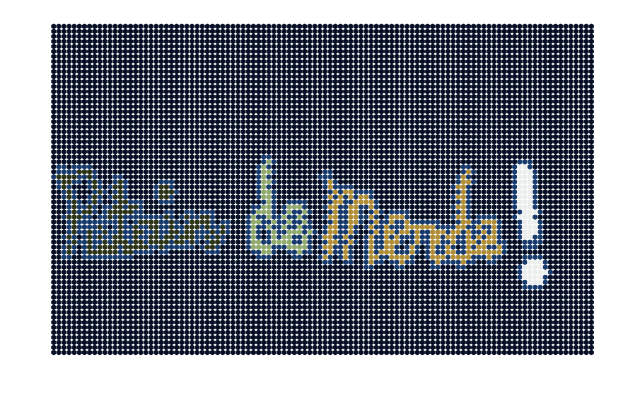

In [29]:
#viz existing map
map_colors=mapplots['TerrainType'].apply(lambda x:terrain2color[x]).tolist()
ax=plt.figure(figsize=(mapw/10,maph/10)).add_subplot(111)
plt.scatter([j for i in range(maph) for j in range(mapw)],
    [i for i in range(maph) for j in range(mapw)],
    s=20,marker='h',
    c=map_colors)
plt.axis('off')
plt.show()

### create map

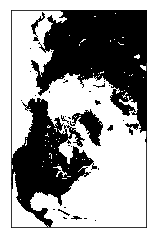

In [30]:
#create map
m=Basemap(projection=projection_type,
              lon_0=lon_centre,
              lat_0=lat_centre,
              width=maph*scaler,
              height=mapw*scaler,)

#show land and sea in different colors
m.drawlsmask(land_color='k',
    ocean_color='w',)

#save image
plt.savefig('mask.png',bbox_inches='tight',
            pad_inches=-.05)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


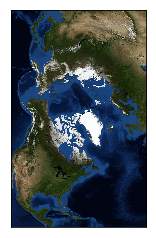

In [31]:
#create map
m=Basemap(projection=projection_type,
              lon_0=lon_centre,
              lat_0=lat_centre,
              width=maph*scaler,
              height=mapw*scaler,)

#blue marble is my fav
#it is similar to google earth
#m.shadedrelief()
#the problem with shaded relief is
#it is harder to distinguish different terrains for computers
#m.etopo()
#the problem with etopo is
#brown represents mountains instead of desert
m.bluemarble()

#you can draw country border to assist you in true start location
#m.drawcountries()

#draw river for map creation is a bad idea
#since river is in a separate table from Plots
#m.drawrivers()

plt.savefig('plot.png',bbox_inches='tight',
            pad_inches=-.05)

In [32]:
#scale down into civmap
img=cv2.imread('plot.png')
new_img=cv2.resize(img,dsize=(maph,mapw,),
           interpolation=cv2.INTER_LANCZOS4)
cv2.imwrite('plot.png',new_img)

#scale down into civmap
img=cv2.imread('mask.png')
new_img=cv2.resize(img,dsize=(maph,mapw,),
           interpolation=cv2.INTER_LANCZOS4)
cv2.imwrite('mask.png',new_img)

True

### map foundation

In [33]:
#read image into numpy array
img=cv2.imread('mask.png',1)

#draw the border between land and sea
#rotate 90 to fit civmap
lsmask=cluster_predict(cv2.rotate(img,
            cv2.cv2.ROTATE_90_CLOCKWISE),masque)

#read image into numpy array
img=cv2.imread('plot.png',1)

#get simplified colors
#rotate 90 to fit civmap
assignment=cluster_predict(cv2.rotate(img,
            cv2.cv2.ROTATE_90_CLOCKWISE),color2terrain)

In [34]:
#sanity check on land/sea
result=check_land_sea(assignment,lsmask,color2terrain)

In [35]:
#map color to terrain
mapplots['TerrainType']=[list(color2terrain.values())[i] for i in result]

#search ocean tiles
ocean_tiles=mapplots[mapplots['TerrainType']=='TERRAIN_OCEAN'].index.tolist()

#find coast and ocean id
coast_id=list(color2terrain.values()).index('TERRAIN_COAST')
ocean_id=list(color2terrain.values()).index('TERRAIN_OCEAN')

#iterate through all ocean tiles
for i in ocean_tiles:

    #compute neighbor ids
    #eliminate negative ids and overflow ids
    neighbor_ids=[i+1,i-1,i-mapw,i-mapw-1,i-mapw+1,i+mapw,i+mapw-1,i+mapw+1]
    neighbor_ids=[i for i in neighbor_ids if i>=0 and i<maph*mapw]

    #neighbors of ocean tiles must be ocean/coast tiles
    #otherwise switch to coast tiles
    if set(result[neighbor_ids]).issubset(set([coast_id,ocean_id])):
        pass
    else:
        result[i]=coast_id

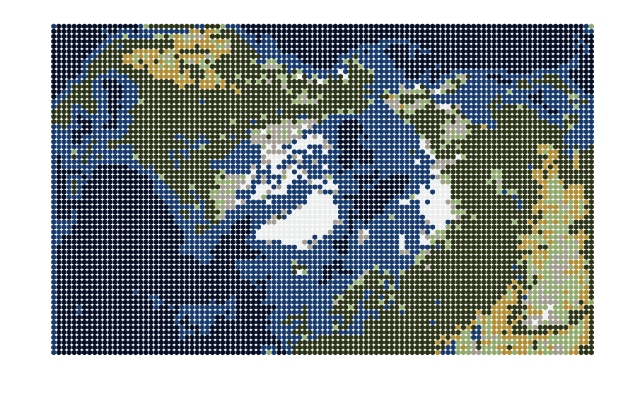

In [36]:
#update ocean tile
mapplots['TerrainType']=[list(color2terrain.values())[i] for i in result]

#viz new map
map_colors=mapplots['TerrainType'].apply(lambda x:terrain2color[x]).tolist()
ax=plt.figure(figsize=(mapw/10,maph/10)).add_subplot(111)
plt.scatter([j for i in range(maph) for j in range(mapw)],
    [i for i in range(maph) for j in range(mapw)],
    s=20,marker='h',
    c=map_colors)
plt.axis('off')
plt.show()

In [37]:
#initialize continent and impassable
mapplots['ContinentType']=''
mapplots['IsImpassable']=0

### continent

In [38]:
#get latitude longitude boundary
bndlon=m.boundarylons.copy()
bndlat=m.boundarylats.copy()

#basemap longitude is weird 
#it does not follow [-180,180]
bndlon[bndlon<-180]=bndlon[bndlon<-180]+360
bndlon[bndlon>180]=bndlon[bndlon>180]-360

#filter available continents
continent_available=get_available_continent(
                        bndlon,bndlat,
                        lon_centre,lat_centre,
                        continent_area)

#iterate through all available continents
dict_cont={}
for val in continent_available:
    lats=continent_area[val]['lat']
    lons=continent_area[val]['lon']

    basemapfile=Basemap(projection=projection_type,
                  lon_0=lon_centre,
                  lat_0=lat_centre,
                  width=maph*scaler,
                  height=mapw*scaler,)

    #draw lsmask
    basemapfile.drawlsmask(land_color='w',
                           ocean_color='w',)
    
    #plot polygon shape continent
    plot_continent(basemapfile,lats,lons)

    #save image
    plt.savefig('continent.png',bbox_inches='tight',
                    pad_inches=-.05)
    plt.clf()
        
    #down scale image
    img=cv2.imread('continent.png')
    img=cv2.resize(img,dsize=(maph,mapw,),
                   interpolation=cv2.INTER_LANCZOS4)

    #get target id
    target_id=get_target_id(img,masque,group=True)
    dict_cont[val]=target_id

<Figure size 432x288 with 0 Axes>

In [39]:
#geotagging continents
for i in dict_cont:
    if dict_cont[i].shape[0]>0:
        mapplots['ContinentType'].loc[dict_cont[i]]=i

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [40]:
#ocean does not belong to any continent
mapplots['ContinentType'][mapplots[
    'TerrainType'].isin(
    ['TERRAIN_COAST','TERRAIN_OCEAN'])]=''

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### natural wonders

In [41]:
#filter targets based upon coordinates
nature_available=filter_coordinates(m,nature)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [42]:
#iterate through natural wonders
nature_dict=itr_targets(lon_centre,lat_centre,
            maph,mapw,scaler,
            nature_available,masque,
                projection_type=projection_type)

<Figure size 432x288 with 0 Axes>

In [43]:
#create dataframe
plotfeatures=pd.DataFrame(columns=['ID','FeatureType'])
plotfeatures['ID']=nature_dict.keys()
plotfeatures['FeatureType']=nature_dict.values()

In [44]:
#prepare to check for terrains
terrain_check=plotfeatures.merge(nature,left_on='FeatureType',
                  right_on='code',how='left')

#filter cols
terrain_check=terrain_check[['ID','terrain','taille',
                            'impassable']]

In [45]:
#make terrain compatible with natural wonder
for i in terrain_check.index:
    identity=terrain_check['ID'].loc[i]
    terrain_type=terrain_check['terrain'].loc[i]
    mapplots.at[identity,'TerrainType']=terrain_type
        
    #convert neighbor tiles to designated terrains
    if terrain_check['taille'].loc[i]>1:
        neighbor_ids=[identity+1,identity-1,
                      identity-mapw,identity-mapw-1,
                      identity-mapw+1,identity+mapw,
                      identity+mapw-1,identity+mapw+1]
        mapplots['TerrainType'].loc[
            neighbor_ids]=terrain_type
    
    #check if passable
    if terrain_check['impassable'].loc[i]==1:
        mapplots.at[identity,'IsImpassable']=1
        if terrain_check['taille'].loc[i]>1:
            mapplots['IsImpassable'].loc[
                neighbor_ids]=1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [46]:
#mountain areas impassable
mapplots['IsImpassable'][mapplots['TerrainType'].isin(impassable_terrains)]=1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### true start locations

In [47]:
#filter targets based upon coordinates
tsl_available=filter_coordinates(m,tsl)

In [48]:
#iterate through true start locations
tsl_dict=itr_targets(lon_centre,lat_centre,
            maph,mapw,scaler,
            tsl_available,masque,
            name_col='code',
            projection_type=projection_type)

<Figure size 432x288 with 0 Axes>

In [49]:
#create start position dataframe
startpos=pd.DataFrame(columns=['Plot',
                               'Type',
                               'Value'])
startpos['Plot']=tsl_dict.keys()
startpos['Type']='LEADER'
startpos['Value']=[i for i in tsl_dict.values()]

In [50]:
#recreate players table
players=pd.DataFrame(human_player)

#count number of city states
spfilter=startpos['Value'].apply(lambda x:1 if 'LEADER_MINOR_CIV_' in x else 0)

#repeat civs
sub1=pd.DataFrame(ai_civs)
sub1=sub1.loc[sub1.index.repeat(len(spfilter)-len(spfilter[spfilter==1])-1)]

#repeat city states
sub2=pd.DataFrame(ai_cities)
sub2=sub2.loc[sub2.index.repeat(len(spfilter[spfilter==1]))]

#create players
players=players.append(sub1).append(sub2)
players.reset_index(inplace=True,drop=True)
players['ID']=players.index

In [51]:
#check players spawn in impassable terrains
player_check=mapplots.merge(startpos,right_on=['Plot'],
               left_on=['ID'],
              how='right')
player_check=player_check[
    player_check['TerrainType'].isin(
        impassable_terrains+['TERRAIN_COAST',
                             'TERRAIN_OCEAN'])]

#exclude maori which starts off at ocean tile
player_check=player_check[player_check['Value']!='LEADER_KUPE']

In [52]:
#assign leaders to available neighbor tiles
player_checklist=[]
for identity in player_check['ID']:
    neighbor_ids=[identity+1,identity-1,
                      identity-mapw,identity-mapw-1,
                      identity-mapw+1,identity+mapw,
                      identity+mapw-1,identity+mapw+1]
    neighbors=mapplots.loc[neighbor_ids]    
    available_neighbors=neighbors[~neighbors[
        'TerrainType'].isin(
        impassable_terrains+['TERRAIN_COAST',
                             'TERRAIN_OCEAN'])]
    if not available_neighbors.empty:
        startpos['Plot'][
            startpos['Value']==tsl_dict[
                identity]]=available_neighbors.index[0]
    
    #if neighbor tiles are not available
    #delete tsl of this leader and raise error
    else:
        player_checklist.append(tsl_dict[identity])
        startpos.drop(startpos[
            startpos['Plot']==identity].index,
                      inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


### resource

In [53]:
#required features and terrains for resources
resource['features']=resource['resource'].apply(lambda x:resource_mapping[x]['features'])
resource['terrains']=resource['resource'].apply(lambda x:resource_mapping[x]['terrains'])

In [54]:
#create empty dataframe
plotresources=pd.DataFrame(columns=['ID',
                                    'ResourceType',
                                    'ResourceCount'])

In [55]:
#check terrain with natural wonders
resource_check=mapplots.merge(plotfeatures,on='ID',
              how='left')

In [56]:
#iterate through different resources
resource_checklist=[]
for resource_name in resource_scarcity:
    target_ids=itr_multi(
        resource[resource['resource']==resource_name],
          lon_centre,lat_centre,
          maph,mapw,scaler,masque,
          resource_scarcity[resource_name])

    #check resource availability based on terrains and features
    available_terrains=resource['terrains'][
        resource['resource']==resource_name].iloc[
        0].split(';')
    available_features=resource['features'][
        resource['resource']==resource_name].fillna('').iloc[
        0]
    for i in [ii for ii in target_ids]:
        existing_terrain=resource_check['TerrainType'].loc[
            i]
        stop=False

        #resource can only exist on specific terrains and features
        for j in available_terrains:
            if existing_terrain in j and (pd.isna(
                resource_check[
            'FeatureType'].loc[i]) or resource_check[
            'FeatureType'].loc[i] in available_features):
                mapplots.at[i,'TerrainType']=j
                stop=True
                break
        if stop:
            continue
        else:

            #remove resource if conditions are not met
            target_ids=np.delete(target_ids,
                                 np.where(target_ids==i))

    #convert to dataframe
    subset=pd.DataFrame(columns=['ID',
                                'ResourceType',
                                'ResourceCount'])
    subset['ID']=target_ids
    subset['ResourceType']=resource_name
    subset['ResourceCount']=1
    plotresources=plotresources.append(subset)
    
    if len(subset)==0:
        resource_checklist.append(resource_name)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\collections.py:902: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


<Figure size 432x288 with 0 Axes>

### update civmap database

In [57]:
text=''

if len(player_checklist)>0:
    text+=f"""\nmanually assign TSL of 
        {', '.join(player_checklist)}\n"""
    
if len(resource_checklist)>0:
    text+=f"""manually assign location of 
        {', '.join(resource_checklist)}\n"""
    
if len(player_checklist)>0 and \
len(resource_checklist)>0:
    assert False,text

AssertionError: 
manually assign TSL of 
        LEADER_MINOR_CIV_CAGUANA
manually assign location of 
        RESOURCE_GYPSUM


In [62]:
#new name
modtext.to_sql('ModText',
               con=con,if_exists='replace',
               index=False)

In [63]:
#upsert map into database
mapplots.to_sql('Plots',
                con=con,if_exists='replace',
                index=False)

In [64]:
#remove all features
con.execute("DELETE FROM PlotFeatures;");
con.commit()

#upsert into database
plotfeatures.to_sql('PlotFeatures',
                    con=con,if_exists='replace',
                    index=False)

In [65]:
#remove all resources
con.execute("DELETE FROM PlotResources;");
con.commit()

#upsert into database
plotresources.to_sql('PlotResources',
                     con=con,if_exists='replace',
                     index=False)

In [66]:
#remove all cliffs
con.execute("DELETE FROM PlotCliffs;");
con.commit()

In [67]:
#update tsl
con.execute("DELETE FROM StartPositions;");
con.commit()
con.execute("DELETE FROM PlayerAttributes;");
con.commit()
con.execute("DELETE FROM Players;");
con.commit()

startpos.to_sql('StartPositions',
                con=con,if_exists='replace',
                index=False)
players.to_sql('Players',con=con,
               if_exists='replace',index=False)

In [68]:
#revert back to civ6map
con.close()
os.rename('civ.db','arctique.Civ6Map')

In [69]:
# # k means to get centroid colors
# # useful when you prefer other types of viz to show topographic map

# from sklearn.cluster import KMeans
# X=img.reshape(mapw*maph,3)[:,[2,1,0]]
# clf=KMeans(n_clusters=6)
# clf.fit(X)
# centroids=[i for i in range(clf.cluster_centers_.shape[0])]
# for i in range(clf.cluster_centers_.shape[0]):
#     centroids[i]=rgb_to_hex(tuple([int(np.ceil(j)) for j in clf.cluster_centers_[i].tolist()]))
# print(centroids)
# plt.scatter(range(6),range(6),c=centroids,s=500)
# plt.show()

In [70]:
# #viz new map
# map_colors=mapplots['TerrainType'].apply(lambda x:terrain2color[x]).tolist()
# plt.scatter([j for i in range(maph) for j in range(mapw)],
#     [i for i in range(maph) for j in range(mapw)],
#     s=20,marker='h',alpha=0.5,
#     c=map_colors)

# for i in player_check['ID']:
#     plt.scatter(i%mapw,i//mapw,label=tsl_dict[i])
# plt.legend(loc=8,bbox_to_anchor=(0,-.5),
#           ncol=2)
# plt.axis('off')
# plt.show()